<a href="https://colab.research.google.com/github/singhnidh/Plant-disease-detection-using-Deep-Learning-and-Machine-Vision/blob/main/Model/2__FINAL_INCEPTIONNET_v3_tl_ft_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**3.2 - inceptionnet v3  transfer learning with fine tune**

In [ ]:
import os
from keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

In [ ]:
dataset_path = "/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ dataset_original"
class_labels = os.listdir(dataset_path)
class_counts = {}
total_count = 0

for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    num_images = len(os.listdir(class_path))
    class_counts[label] = num_images
    total_count += num_images

for label, count in class_counts.items():
    print(f"Class: {label}, Number of Images: {count}")

print(f"Total Number of Images: {total_count}")


Class: Blueberry___healthy, Number of Images: 1502
Class: Apple___Cedar_apple_rust, Number of Images: 277
Class: Apple___healthy, Number of Images: 1646
Class: Cherry_(including_sour)___healthy, Number of Images: 863
Class: Cherry_(including_sour)___Powdery_mildew, Number of Images: 1064
Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, Number of Images: 515
Class: Corn_(maize)___Common_rust_, Number of Images: 1200
Class: Corn_(maize)___healthy, Number of Images: 1162
Class: Corn_(maize)___Northern_Leaf_Blight, Number of Images: 985
Class: Grape___Black_rot, Number of Images: 1181
Class: Grape___Esca_(Black_Measles), Number of Images: 1383
Class: Grape___healthy, Number of Images: 423
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Number of Images: 1077
Class: Pepper,_bell___Bacterial_spot, Number of Images: 987
Class: Pepper,_bell___healthy, Number of Images: 1476
Class: Potato___Early_blight, Number of Images: 1000
Class: Potato___healthy, Number of Images: 152
Class: P

In [ ]:
dataset_path = "/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset"
class_labels = os.listdir(dataset_path)
class_counts = {}
total_count = 0
for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    num_images = len(os.listdir(class_path))
    class_counts[label] = num_images
    total_count += num_images
for label, count in class_counts.items():
    print(f"Class: {label}, Number of Images: {count}")

print(f"Total Number of Images: {total_count}")

Class: Corn_(maize)___Common_rust_, Number of Images: 500
Class: Grape___Black_rot, Number of Images: 500
Class: Corn_(maize)___healthy, Number of Images: 500
Class: Grape___Esca_(Black_Measles), Number of Images: 500
Class: Pepper,_bell___healthy, Number of Images: 500
Class: Apple___healthy, Number of Images: 500
Class: Apple___Cedar_apple_rust, Number of Images: 507
Class: Cherry_(including_sour)___healthy, Number of Images: 500
Class: Cherry_(including_sour)___Powdery_mildew, Number of Images: 500
Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, Number of Images: 500
Class: Corn_(maize)___Northern_Leaf_Blight, Number of Images: 501
Class: Grape___healthy, Number of Images: 493
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Number of Images: 500
Class: Pepper,_bell___Bacterial_spot, Number of Images: 500
Class: Potato___Early_blight, Number of Images: 500
Class: Potato___healthy, Number of Images: 476
Class: Potato___Late_blight, Number of Images: 500
Class: Strawberry

In [ ]:
BATCH_SIZE = 64
train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
download_dir = Path('/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset')

train_data_dir = download_dir/' dataset_original'
test_data_dir = download_dir/' Augmented Dataset'

class_subset = os.listdir(download_dir/' dataset_original')
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(299,299),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


Found 16545 images belonging to 20 classes.
Found 2911 images belonging to 20 classes.
Found 10472 images belonging to 20 classes.


In [ ]:
#Using Pre-trained Layers for Feature Extraction
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):

    conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    #top_model = Flatten(name="flatten")(top_model)
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    #top_model = Dropout(0.2)(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    #base_model,
    #layers.GlobalAveragePooling2D(),
    #layers.Dense(256, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(train_data.num_classes, activation='softmax')

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
input_shape = (299, 299, 3)
optim_1 = Adam(learning_rate=0.01)
n_classes=20
n_steps =20 # traingen.samples // BATCH_SIZE
n_val_steps =20 # validgen.samples // BATCH_SIZE
n_epochs = 20

model = create_model(input_shape, n_classes, optim_1, fine_tune=20)

!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/16_t2_another_tl2_2.h5',
                                  save_best_only=True,
                                  verbose=1)
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_18

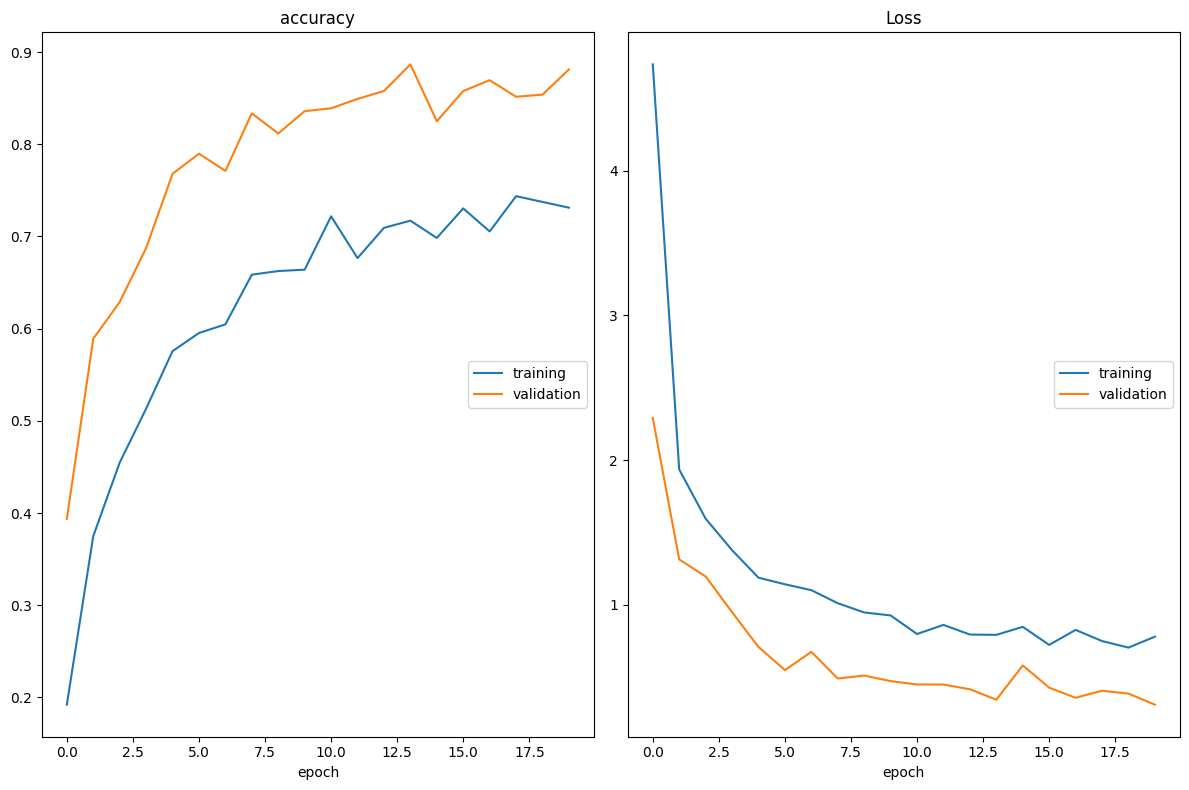

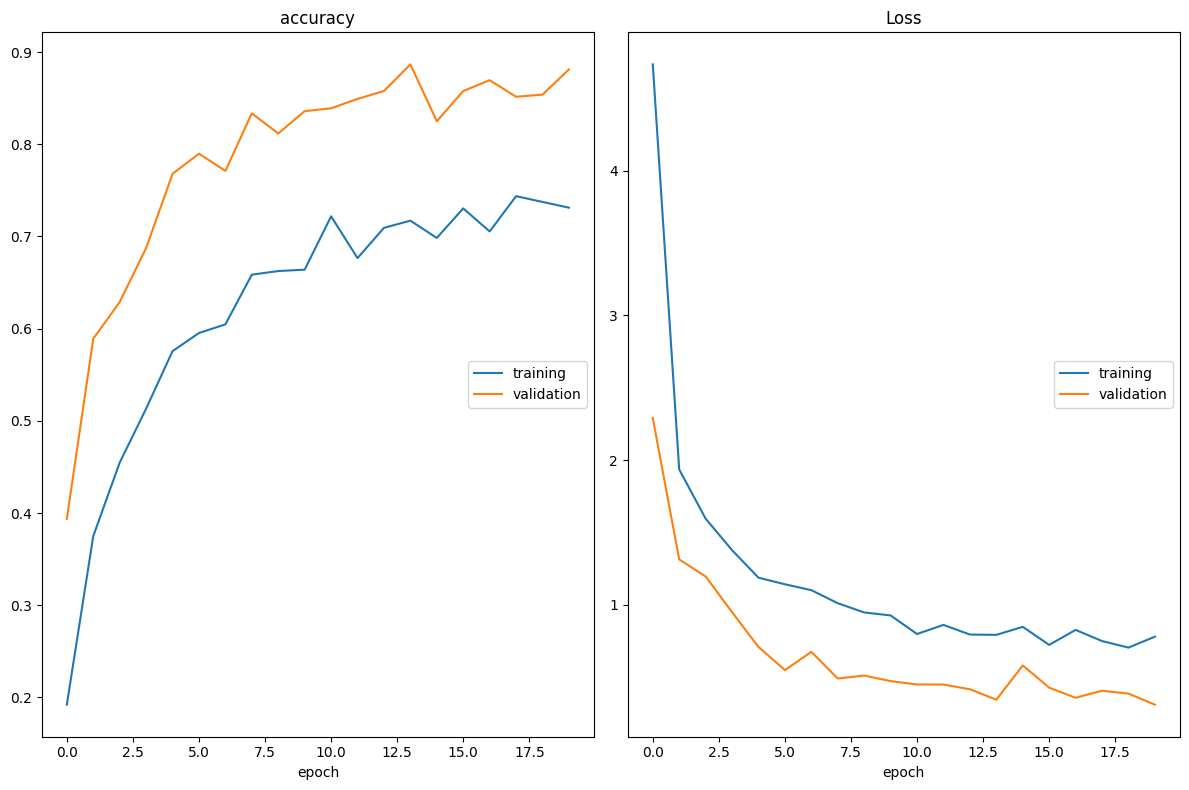

accuracy
	training         	 (min:    0.192, max:    0.744, cur:    0.731)
	validation       	 (min:    0.394, max:    0.887, cur:    0.881)
Loss
	training         	 (min:    0.704, max:    4.735, cur:    0.779)
	validation       	 (min:    0.309, max:    2.291, cur:    0.309)
20/20 [==============================] - 760s 39s/step - loss: 0.7790 - accuracy: 0.7312 - val_loss: 0.3089 - val_accuracy: 0.8813
accuracy
	training         	 (min:    0.192, max:    0.744, cur:    0.731)
	validation       	 (min:    0.394, max:    0.887, cur:    0.881)
Loss
	training         	 (min:    0.704, max:    4.735, cur:    0.779)
	validation       	 (min:    0.309, max:    2.291, cur:    0.309)
20/20 [==============================] - 760s 39s/step - loss: 0.7790 - accuracy: 0.7312 - val_loss: 0.3089 - val_accuracy: 0.8813


In [ ]:
#We can now train the model defined above:

history_0 = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)


#Saving our model
filepath="/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/16_t2_another_tl2_2.h5"
model.save(filepath)

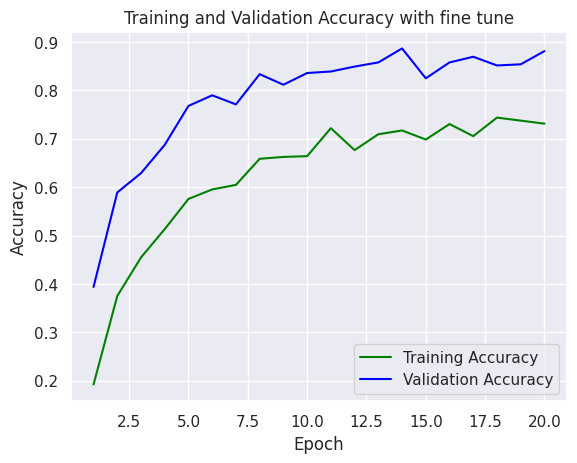

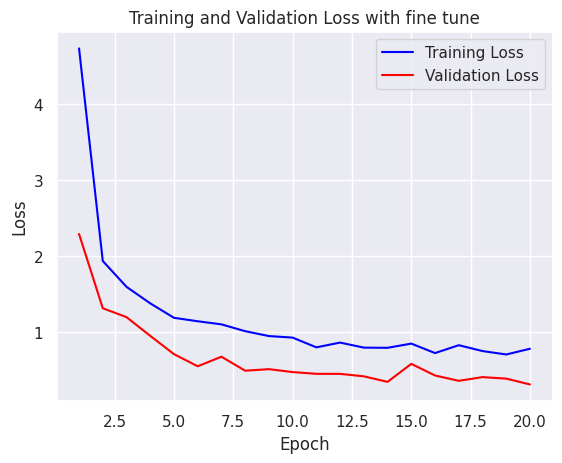

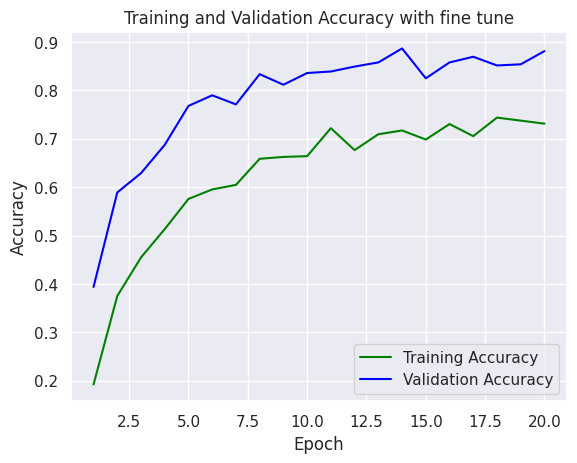

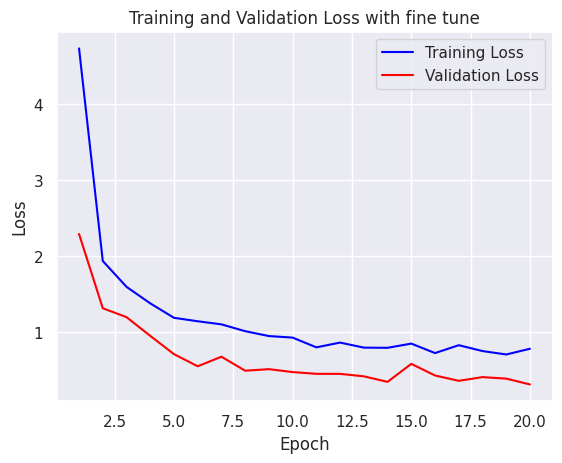

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history_0.history['accuracy']
val_acc = history_0.history['val_accuracy']
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy with fine tune')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss with fine tune')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(testgen)
pred_classes = np.argmax(preds, axis=1)

10472/10472 [==============================] - 2992s 285ms/step


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, pred_classes)
print(" Model Accuracy : {:.2f}%".format(vgg_acc * 100))

 Model Accuracy : 76.43%


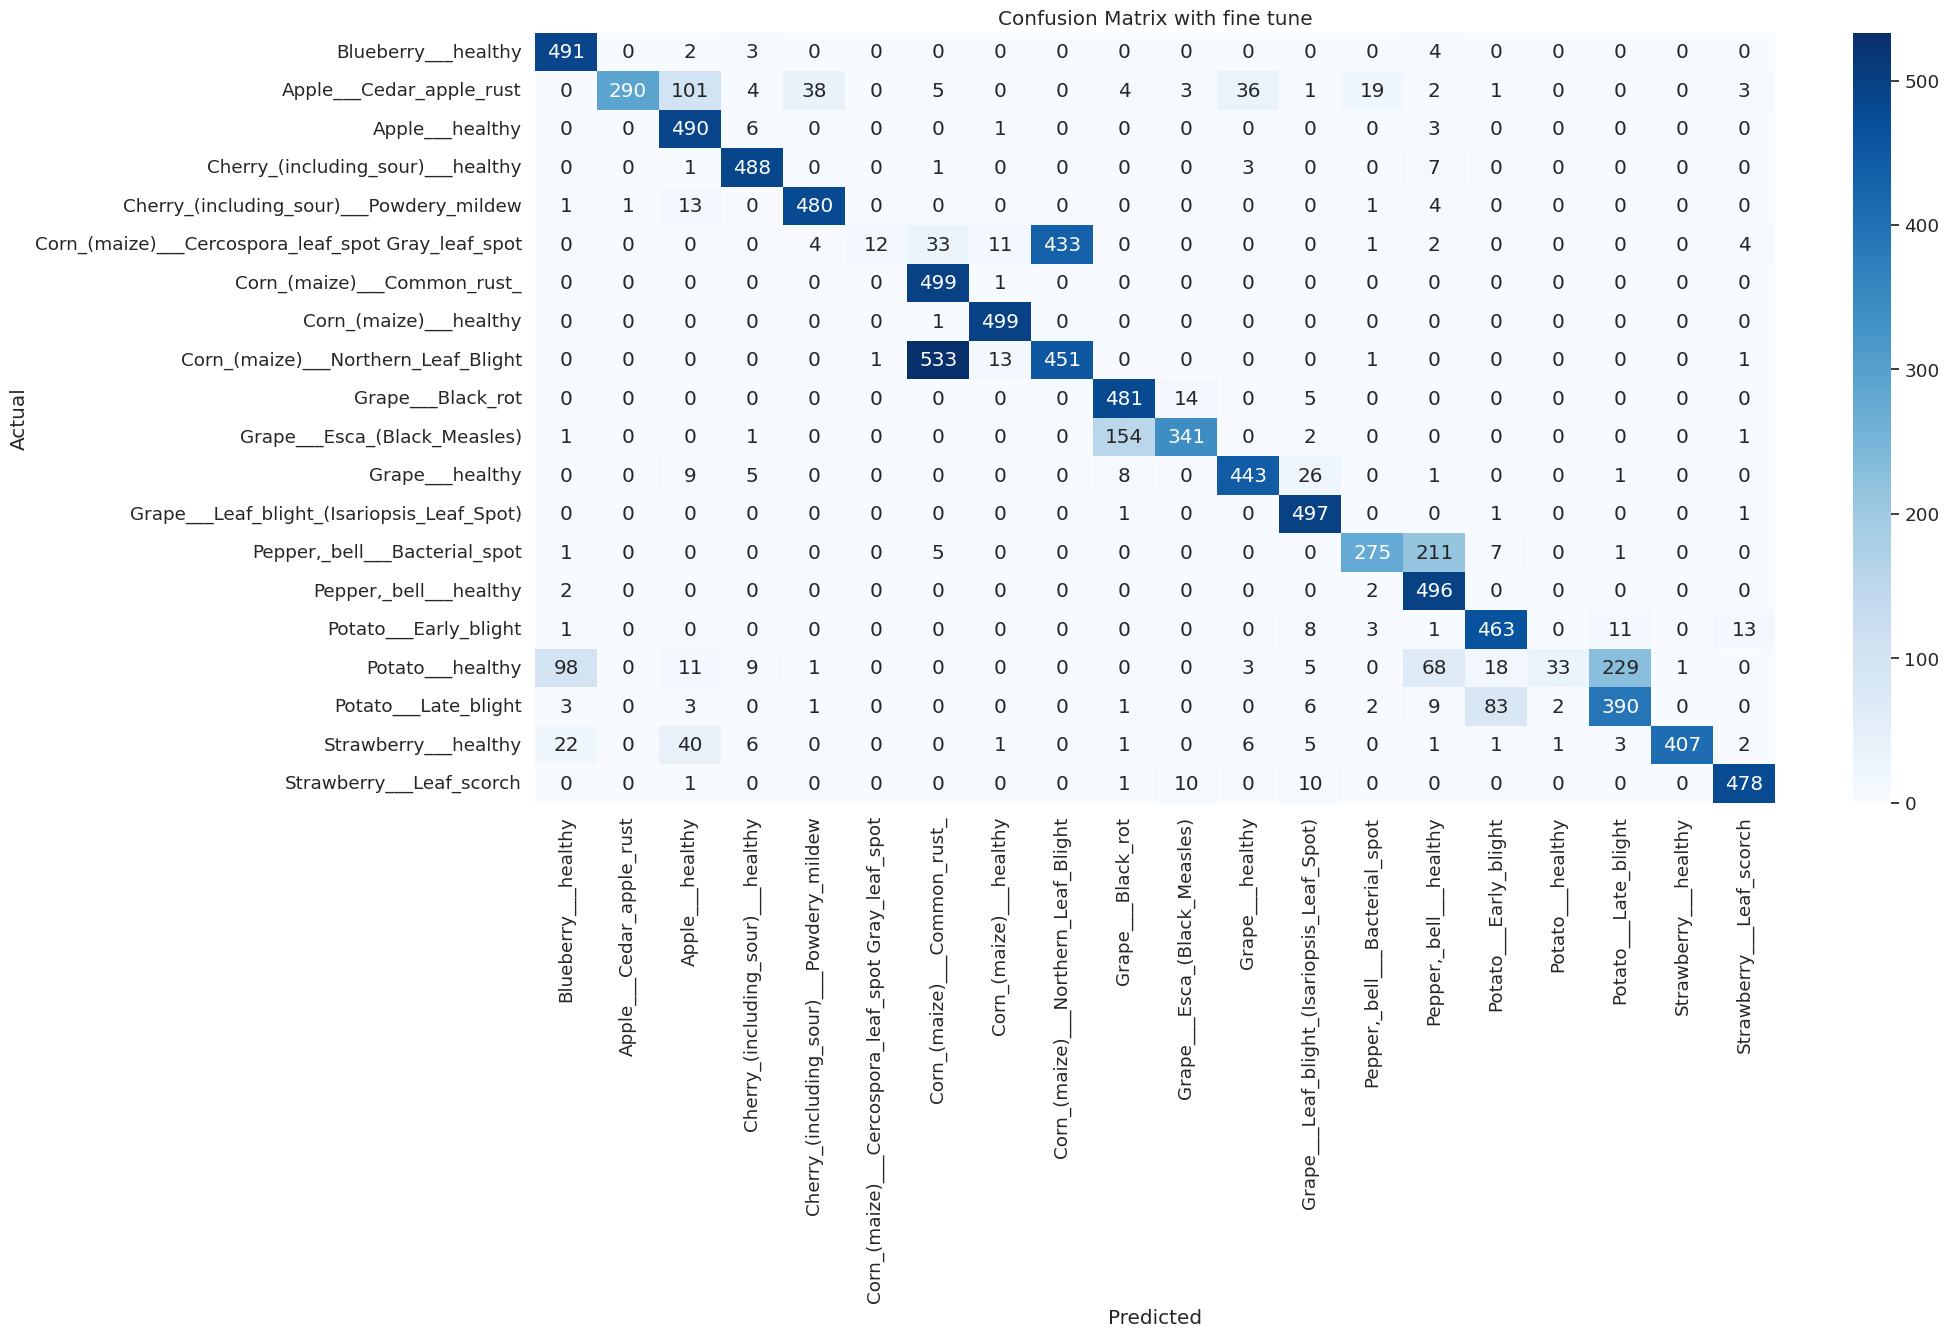

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()


# Create a heatmap
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


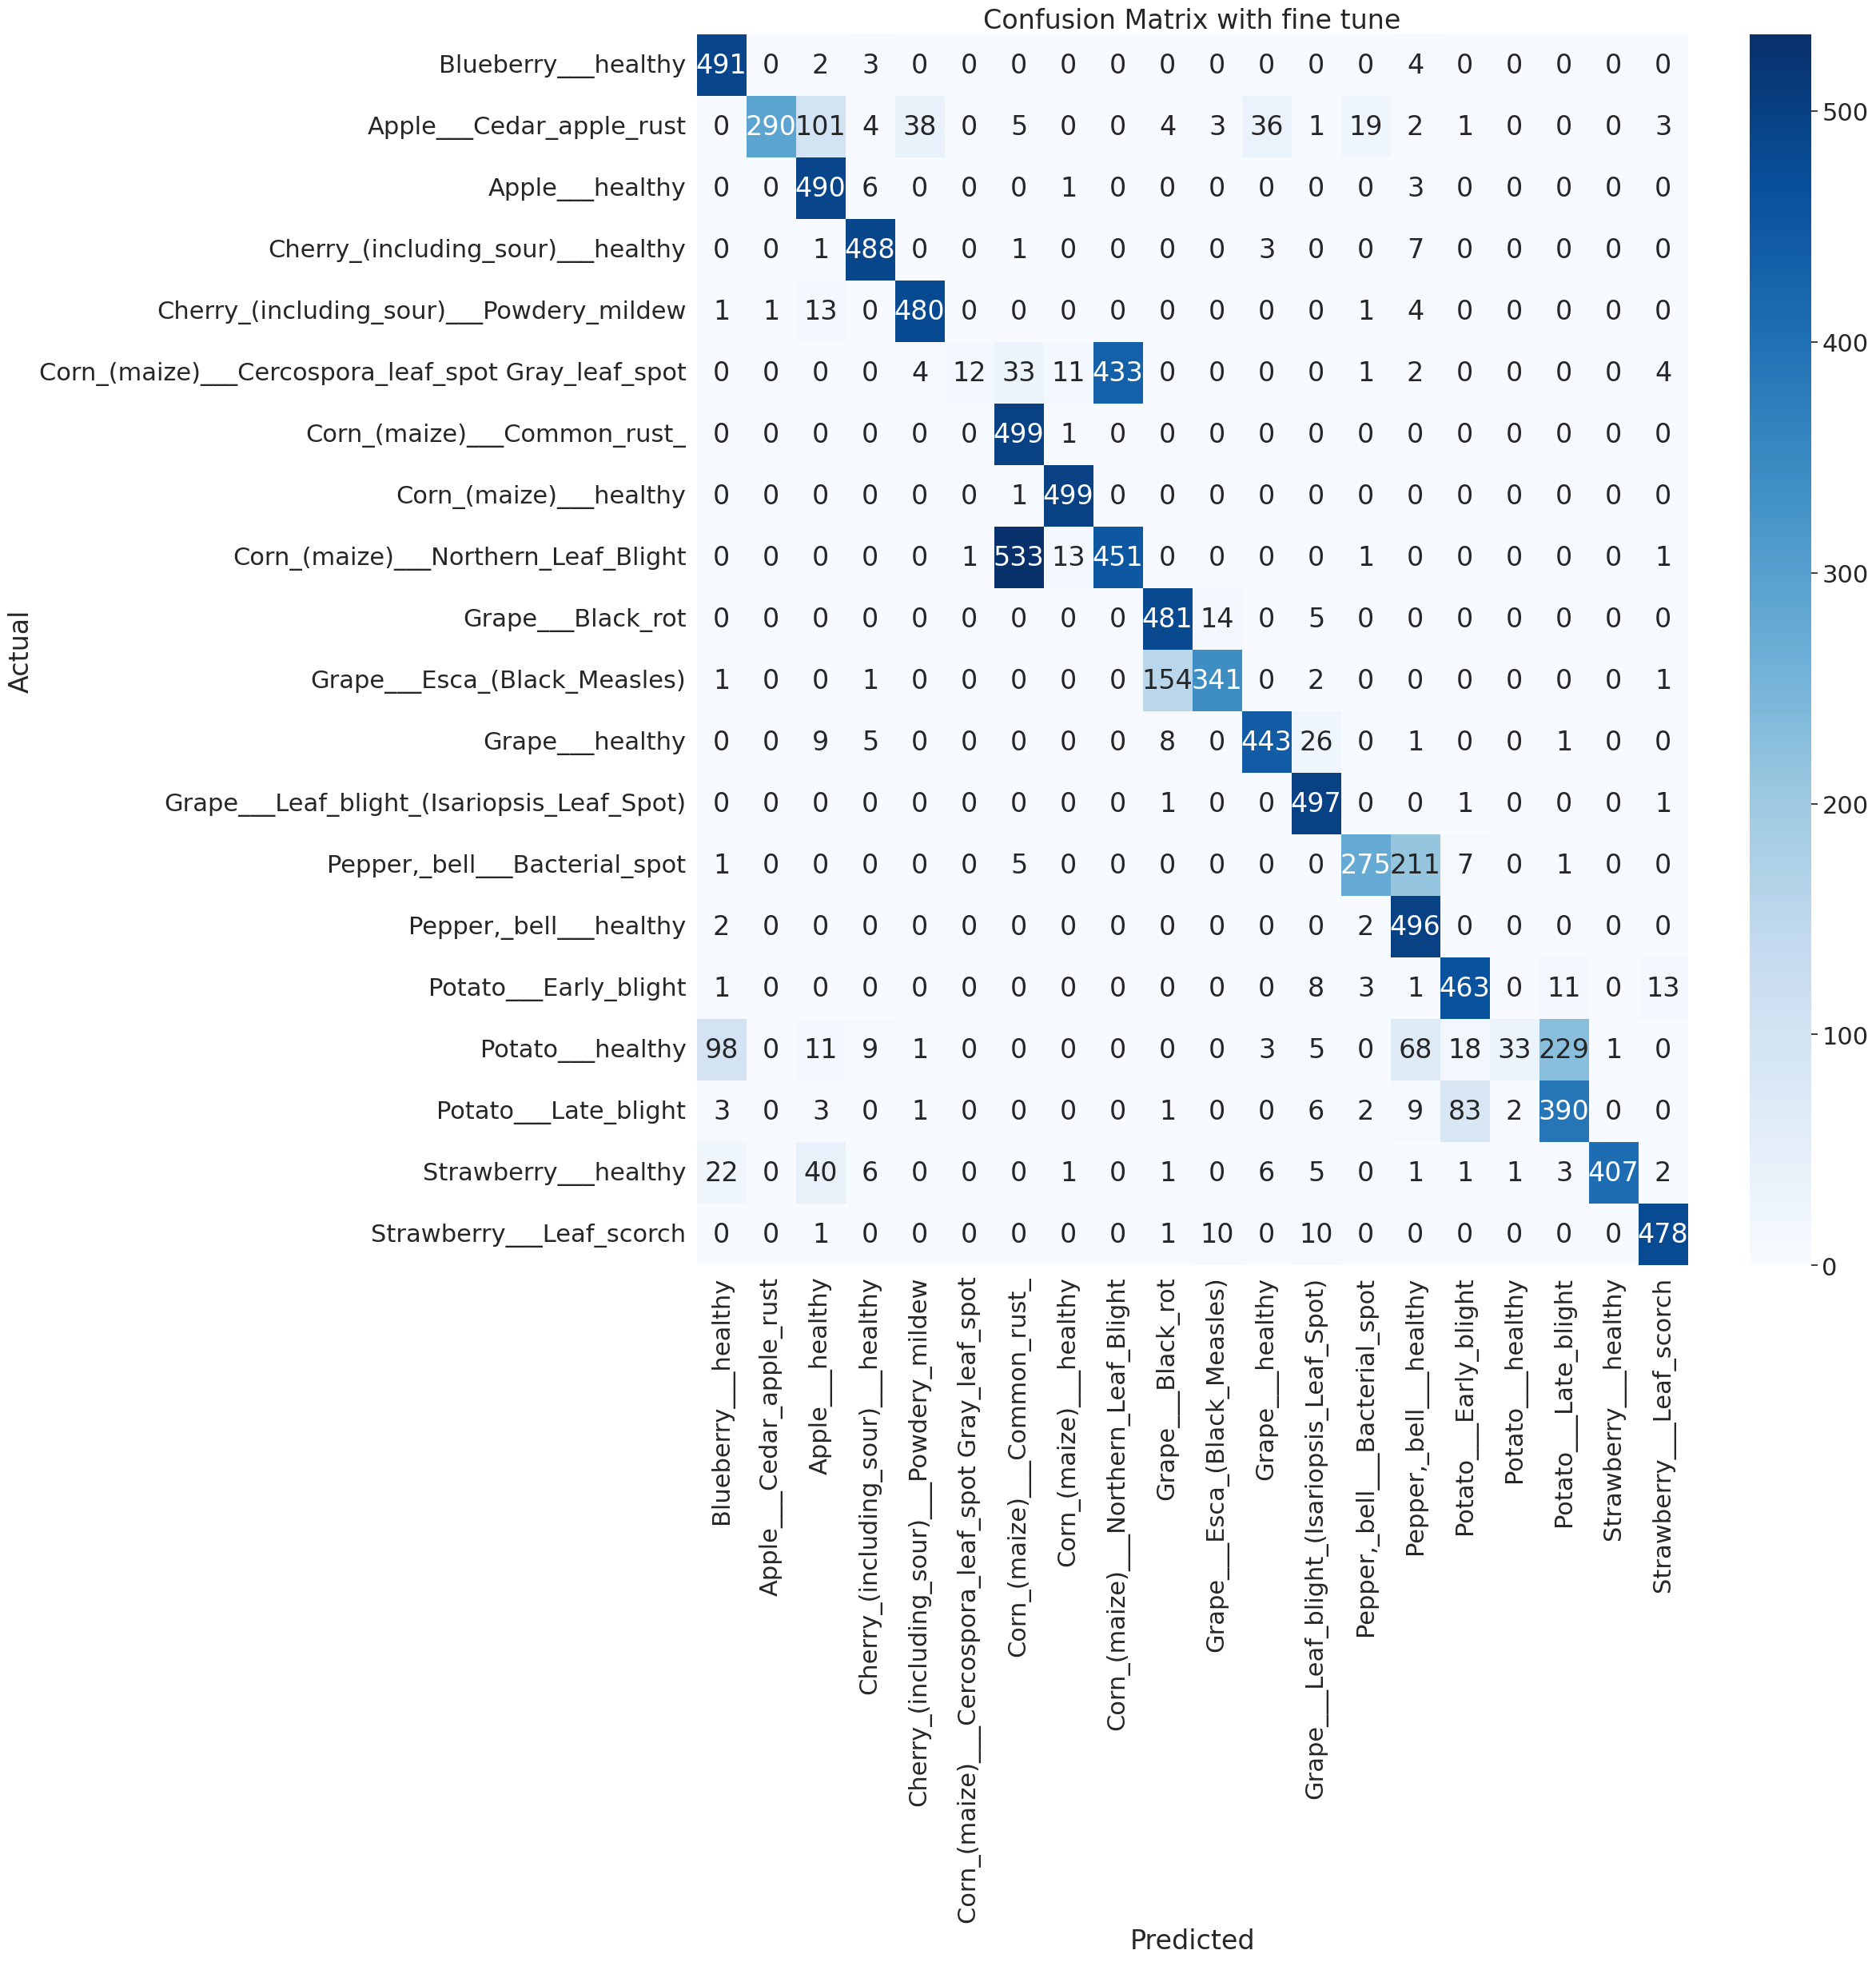

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()


# Create a heatmap
plt.figure(figsize=(20,20))
sns.set(font_scale=2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


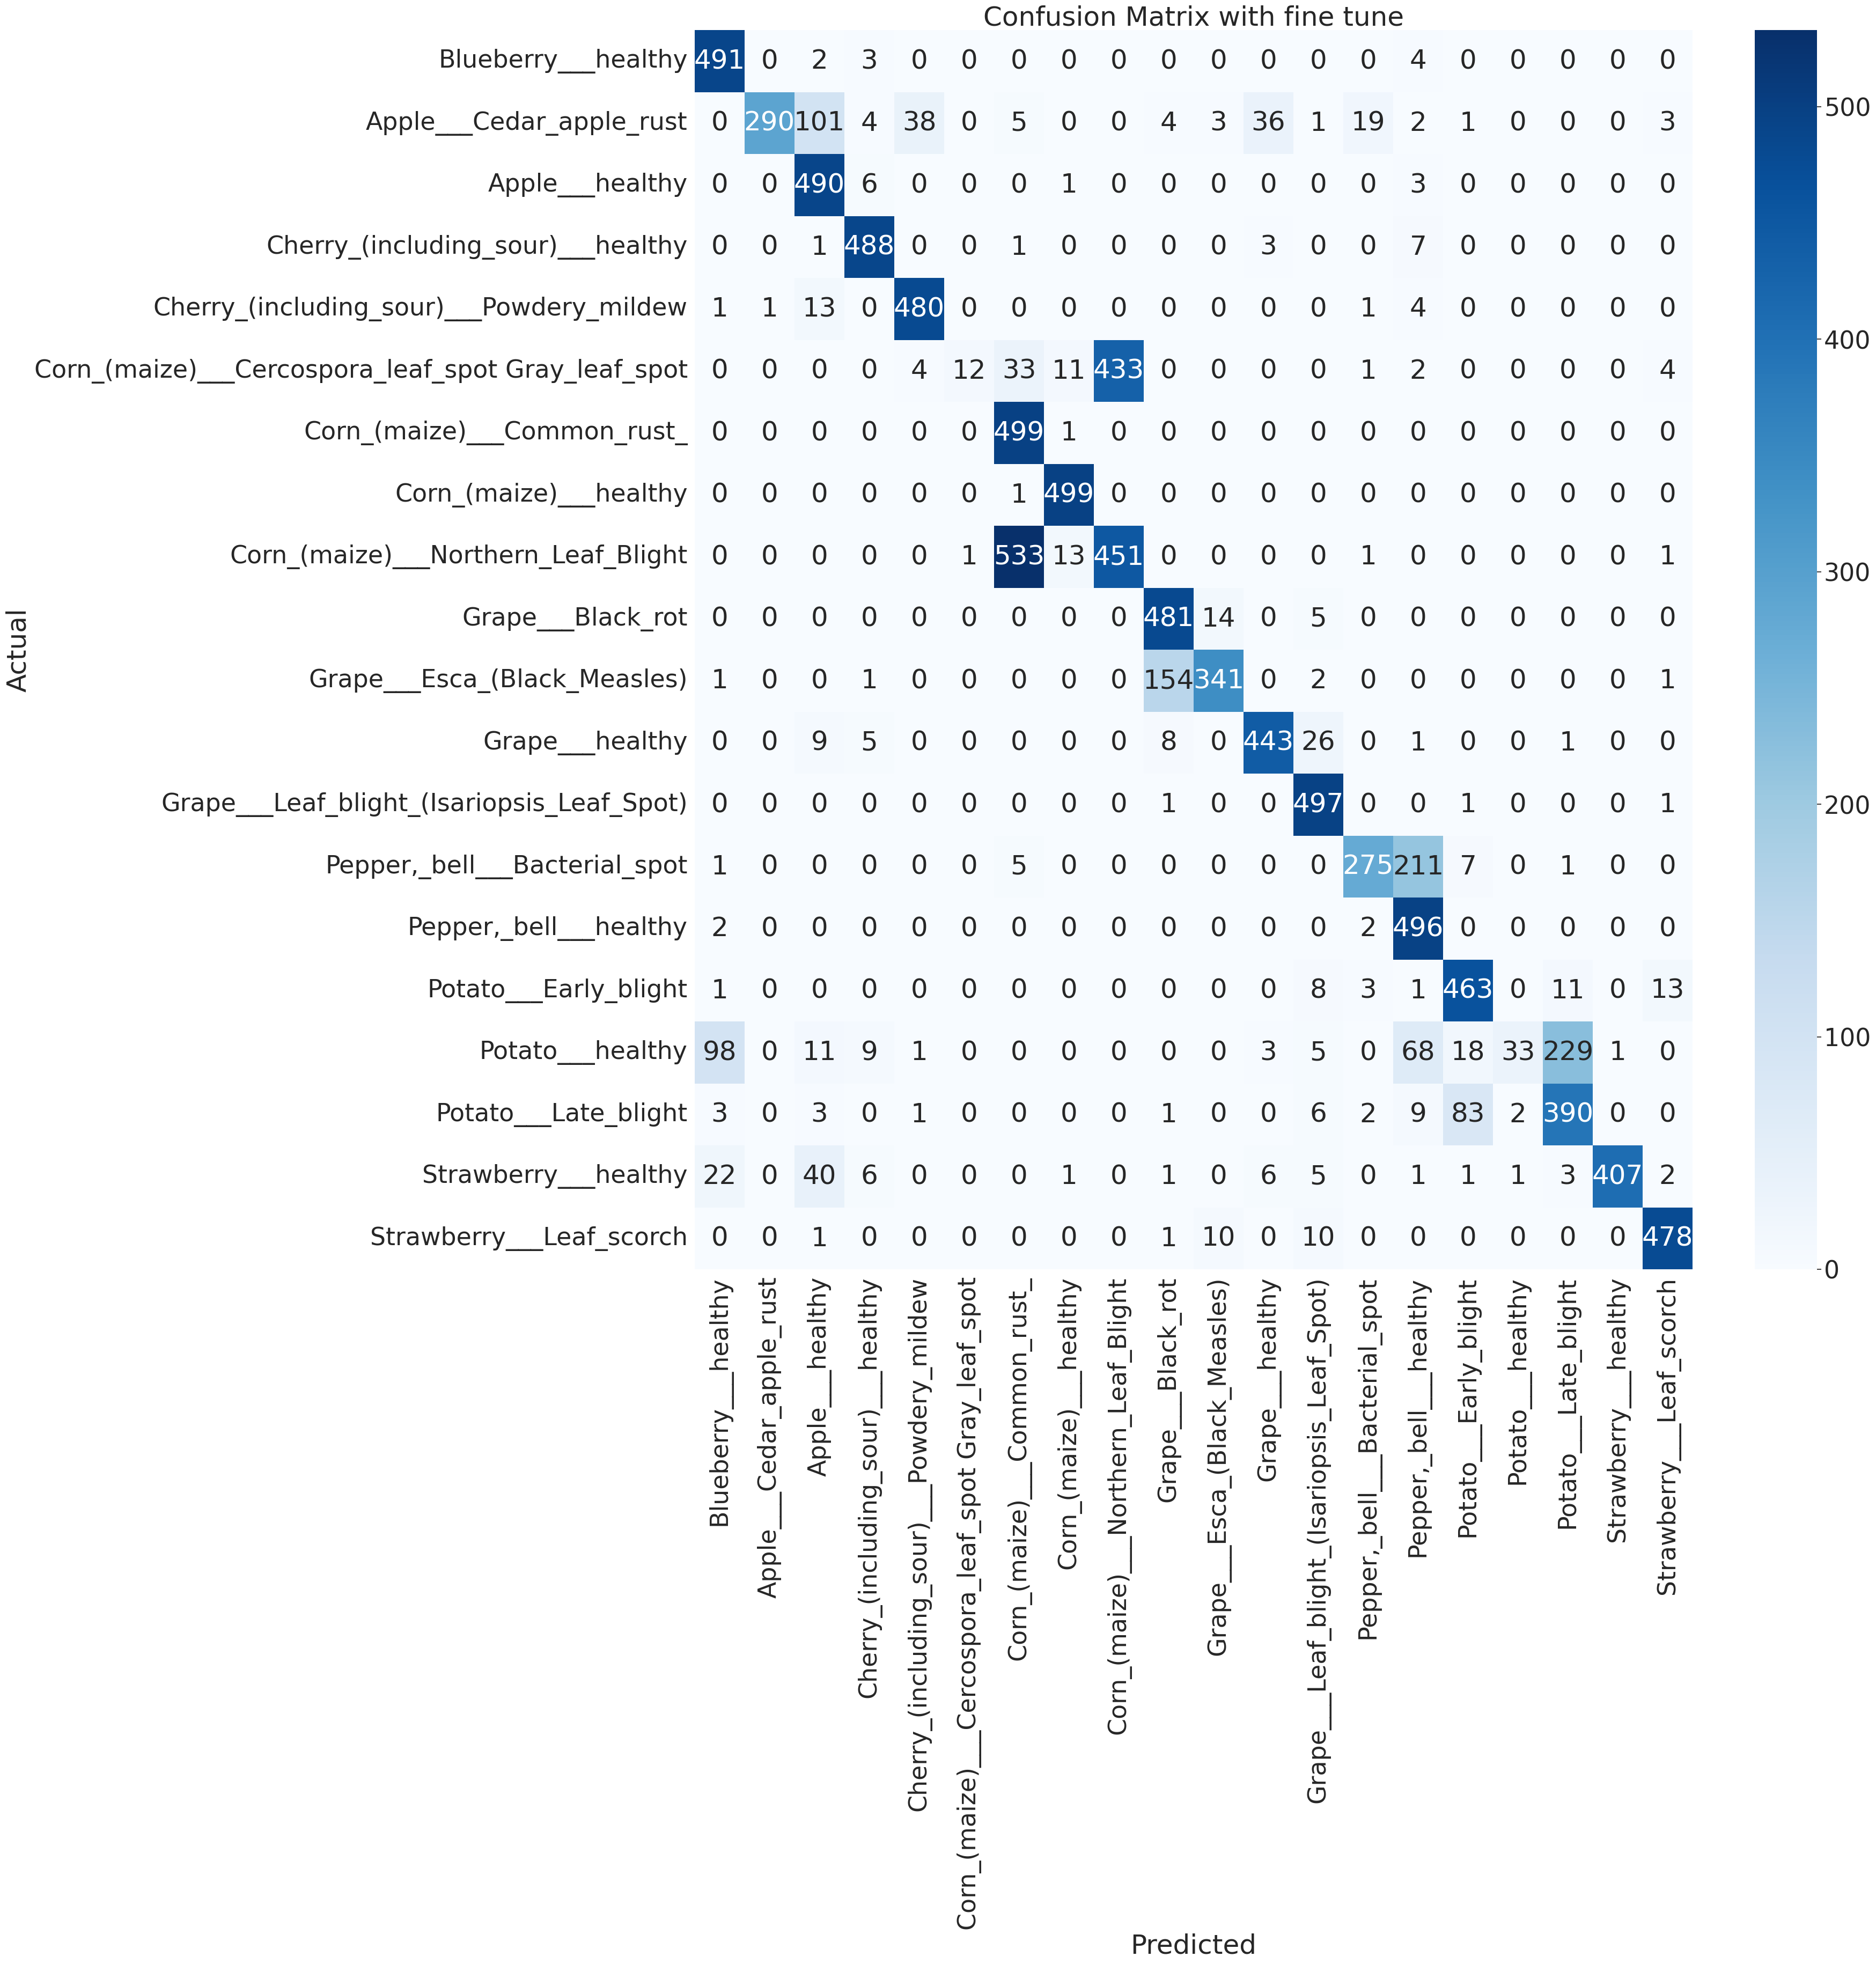

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()


# Create a heatmap
plt.figure(figsize=(30,30))
sns.set(font_scale=3)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


In [ ]:
# Predict on the validation set
#y_pred = vgg_model_ft.predict(testgen)
y_pred = preds
y_true = testgen.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
cm = confusion_matrix(y_true, y_pred_classes)
classification_rep = classification_report(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Display classification report, precision, recall, and F1 score
print("\nClassification Report:")
print(classification_rep)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


Confusion Matrix:
[[491   0   2   3   0   0   0   0   0   0   0   0   0   0   4   0   0   0
    0   0]
 [  0 290 101   4  38   0   5   0   0   4   3  36   1  19   2   1   0   0
    0   3]
 [  0   0 490   6   0   0   0   1   0   0   0   0   0   0   3   0   0   0
    0   0]
 [  0   0   1 488   0   0   1   0   0   0   0   3   0   0   7   0   0   0
    0   0]
 [  1   1  13   0 480   0   0   0   0   0   0   0   0   1   4   0   0   0
    0   0]
 [  0   0   0   0   4  12  33  11 433   0   0   0   0   1   2   0   0   0
    0   4]
 [  0   0   0   0   0   0 499   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   1 499   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   1 533  13 451   0   0   0   0   1   0   0   0   0
    0   1]
 [  0   0   0   0   0   0   0   0   0 481  14   0   5   0   0   0   0   0
    0   0]
 [  1   0   0   1   0   0   0   0   0 154 341   0   2   0   0   0   0   0
    0   1]
 [  0   0   9   5   0   0   0   0   0   8   0 4

1/1 [==============================] - 0s 487ms/step


Text(0.5, 1.0, 'predicted: 0')

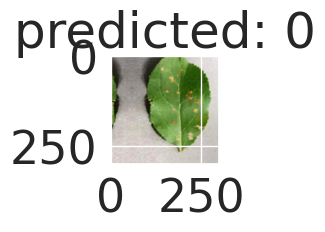

In [ ]:
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

font_scale=1.5
# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Apple___Cedar_apple_rust/aug_0_3915.jpg'
img = image.load_img(img_path, target_size=(299,299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)


1/1 [==============================] - 0s 254ms/step


Text(0.5, 1.0, 'predicted: 0')

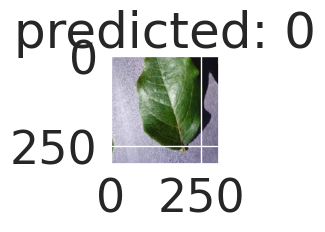

In [ ]:
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

#font_scale=1.5
# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Blueberry___healthy/aug_1037_77.jpg'
img = image.load_img(img_path, target_size=(299,299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)


1/1 [==============================] - 0s 236ms/step


Text(0.5, 1.0, 'predicted: 0')

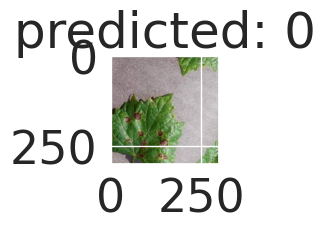

In [ ]:
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

#font_scale=1.5
# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Grape___Black_rot/aug_1010_8853.jpg'
img = image.load_img(img_path, target_size=(299,299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)


1/1 [==============================] - 1s 680ms/step


Text(0.5, 1.0, 'predicted: 14')

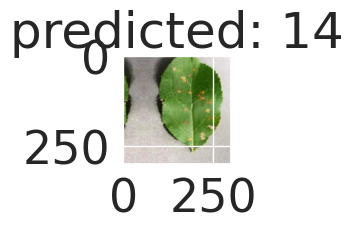

In [ ]:
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

font_scale=1.5
# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Apple___Cedar_apple_rust/aug_0_3915.jpg'
img = image.load_img(img_path, target_size=(299,299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)


1/1 [==============================] - 1s 944ms/step


Text(0.5, 1.0, 'predicted: 0')

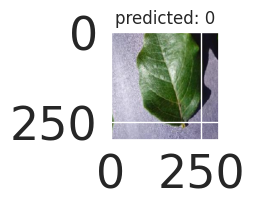

In [ ]:
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

#font_scale=1.5
# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Blueberry___healthy/aug_1037_77.jpg'
img = image.load_img(img_path, target_size=(299,299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted),fontsize=12)
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a generator that generates images during training
# Replace this with your actual generator
def generate_images(traingen, num_images=5):
    # Generate some images
    generated_images = traingen.predict(train_data_dir)  # Replace ... with your actual generator input

    # Display the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i in range(num_images):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')

    plt.show()

# Call the function during training to visualize generated images
# Example:
# for epoch in range(num_epochs):
#     # Training steps...
#     generate_images(generator)


In [ ]:
# Assuming you have already trained your model and now want to evaluate it on test data

# Load your test data and labels
test_data, test_labels = load_test_data()

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data, test_labels)

# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
